In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

dataset építése:

In [2]:
fires = pd.read_csv("C:\\Users\\Bence\\Documents\\Github\\NASA_SpaceApps_challenge_2025\\data\\greece_fire_dates.csv")
places = pd.read_csv("C:\\Users\\Bence\\Documents\\Github\\NASA_SpaceApps_challenge_2025\\data\\greece_fire_places.csv")
weather = pd.read_csv("C:\\Users\\Bence\\Documents\\Github\\NASA_SpaceApps_challenge_2025\\data\\greece_fire_weather.csv")


C:\Users\Bence\AppData\Local\Temp\ipykernel_17096\175859139.py:3: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  weather = pd.read_csv("C:\\Users\\Bence\\Documents\\Github\\NASA_SpaceApps_challenge_2025\\data\\greece_fire_weather.csv")


In [3]:
fires = fires.drop(fires[fires["confidence"] < 100].index)
fires["acq_date"] = pd.to_datetime(fires["acq_date"], errors="coerce")
weather["time"] = pd.to_datetime(weather["time"], errors="coerce")
fires_daily = (
    fires.groupby("acq_date")
    .size()
    .reset_index(name="fire_count")
)
fires_daily["fire_occurred"] = (fires_daily["fire_count"] > 0).astype(int)

In [4]:
places = places.drop(columns=["elevation", "utc_offset_seconds", "timezone", "timezone_abbreviation"])

weather = weather.merge(places, on="location_id", how="left")
numeric_cols = weather.select_dtypes(include=[np.number]).columns
# Group weather by day, aggregate with mean, keep original column names
weather_daily = weather.groupby("time")[numeric_cols].mean().reset_index()

In [5]:
#weather.head().dtypes

In [6]:
# Merge daily weather and fire data for timeseries creation
df = weather_daily.merge(fires_daily, left_on="time", right_on="acq_date", how="left")
# df = df.drop(columns="time")
df["fire_occurred"].fillna(0, inplace=True)
df.drop(columns=["acq_date"], inplace=True, errors="ignore")
#df.head().dtypes

C:\Users\Bence\AppData\Local\Temp\ipykernel_17096\550816031.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["fire_occurred"].fillna(0, inplace=True)


In [7]:
df["fire_count"].fillna(0, inplace=True)
df.sort_values("time", inplace=True)
df.reset_index(drop=True, inplace=True)
print(df.head())

        time  weather_code (wmo code)  temperature_2m_mean (°C)  \
0 2000-01-18                     42.6                      4.70   
1 2000-01-19                     58.6                      5.46   
2 2000-01-20                     26.0                      1.50   
3 2000-01-21                      2.4                      1.64   
4 2000-01-22                     50.2                      4.44   

   temperature_2m_max (°C)  temperature_2m_min (°C)  \
0                     8.66                     0.92   
1                     8.28                     2.20   
2                     4.16                    -1.02   
3                     5.58                    -1.96   
4                     7.96                     0.68   

   apparent_temperature_mean (°C)  apparent_temperature_max (°C)  \
0                            0.68                           3.90   
1                            1.88                           5.80   
2                           -3.18                          -0.

C:\Users\Bence\AppData\Local\Temp\ipykernel_17096\1877599873.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["fire_count"].fillna(0, inplace=True)


In [8]:
window_size = 30  # múltbeli napok
forecast_horizon = 7  # előrejelzési idő

feature_cols = [
    col
    for col in df.columns
    if col
    in [
        "temperature_2m_max (°C)",
        "temperature_2m_min (°C)",
        "apparent_temperature_max (°C)",
        "apparent_temperature_min (°C)",
        #"sunrise (iso8601)",
        #"sunset (iso8601)",
        "daylight_duration (s)",
        "sunshine_duration (s)",
        "precipitation_sum (mm)",
        "rain_sum (mm)",
        "snowfall_sum (cm)",
        "precipitation_hours (h)",
        "wind_speed_10m_max (km/h)",
        "wind_gusts_10m_max (km/h)",
        "wind_direction_10m_dominant (°)",
        "shortwave_radiation_sum (MJ/m²)",
        "et0_fao_evapotranspiration (mm)"
    ]
]
scaler = MinMaxScaler()
df_scaled = df.copy()
df_scaled[feature_cols] = scaler.fit_transform(df_scaled[feature_cols])

X, y = [], []

for i in range(len(df_scaled) - window_size - forecast_horizon):
    past_window = df_scaled.iloc[i : i + window_size][feature_cols].values
    target_window = df_scaled.iloc[
        i + window_size : i + window_size + forecast_horizon
    ]["fire_occurred"]
    X.append(past_window)
    y.append(1 if target_window.max() > 0 else 0)


X = np.array(X)
y = np.array(y).astype(np.float32)

print(f"Input shape: {X.shape}  (samples, time_steps, features)")
print(f"Target shape: {y.shape}")

np.savez_compressed("greece_fire_timeseries.npz", X=X, y=y)


Input shape: (7982, 30, 15)  (samples, time_steps, features)
Target shape: (7982,)


In [13]:
cols_scaled = df_scaled.columns.tolist()
print(len(cols_scaled))
cols_df = df.columns.tolist()
print(len(cols_df))
print(len(feature_cols))
print(feature_cols)

23
23
15
['temperature_2m_max (°C)', 'temperature_2m_min (°C)', 'apparent_temperature_max (°C)', 'apparent_temperature_min (°C)', 'daylight_duration (s)', 'sunshine_duration (s)', 'precipitation_sum (mm)', 'rain_sum (mm)', 'snowfall_sum (cm)', 'precipitation_hours (h)', 'wind_speed_10m_max (km/h)', 'wind_gusts_10m_max (km/h)', 'wind_direction_10m_dominant (°)', 'shortwave_radiation_sum (MJ/m²)', 'et0_fao_evapotranspiration (mm)']


Model tanítás:

In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from sklearn.model_selection import TimeSeriesSplit
import joblib
import datetime

# TensorBoard setup for Keras
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1, write_graph=True, write_images=True)

# Adatok betöltése
data = np.load("greece_fire_timeseries.npz")
X = data["X"]
y = data["y"]

print("Input shape:", X.shape)
print("Target shape:", y.shape)

# Train-test split
tscv = TimeSeriesSplit(n_splits=5)

for fold, (train_idx, test_idx) in enumerate(tscv.split(X)):
    print(f"Fold {fold+1}: Train={len(train_idx)}, Test={len(test_idx)}")
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

# LSTM modell
model = Sequential([
    LSTM(128, input_shape=(X.shape[1], X.shape[2]), return_sequences=True),
    Dropout(0.3),
    LSTM(64),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')  # Kimenet 0-1 között
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
 )

# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Tanítás
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=30,
    batch_size=64,
    callbacks=[early_stop, tensorboard_callback],
    verbose=1
)
# Modell mentése
joblib.dump(model, 'model.pkl')

# Értékelés
loss, acc = model.evaluate(X_test, y_test)
print(f"\n✅ Teszt pontosság: {acc*100:.2f}%")

Input shape: (7982, 30, 15)
Target shape: (7982,)
Fold 1: Train=1332, Test=1330
Fold 2: Train=2662, Test=1330
Fold 3: Train=3992, Test=1330
Fold 4: Train=5322, Test=1330
Fold 5: Train=6652, Test=1330


c:\Users\Bence\Documents\Github\NASA_SpaceApps_challenge_2025\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 9s 49ms/step - accuracy: 0.8235 - loss: 0.4047 - val_accuracy: 0.7932 - val_loss: 0.4440
Epoch 2/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 9s 49ms/step - accuracy: 0.8235 - loss: 0.4047 - val_accuracy: 0.7932 - val_loss: 0.4440
Epoch 2/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.8534 - loss: 0.3613 - val_accuracy: 0.8105 - val_loss: 0.4119
Epoch 3/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.8534 - loss: 0.3613 - val_accuracy: 0.8105 - val_loss: 0.4119
Epoch 3/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.8581 - loss: 0.3513 - val_accuracy: 0.8180 - val_loss: 0.4064
Epoch 4/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.8581 - loss: 0.3513 - val_accuracy: 0.8180 - val_loss: 0.4064
Epoch 4/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.8629 - loss: 0.3434 - val_accuracy: 0.7962 - val_loss: 0.4454
Epoch 5/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.8629 - loss: 0.3434 - val_accu

In [ ]:
# TensorBoard setup for Keras
from tensorflow.keras.callbacks import TensorBoard
import datetime
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1, write_graph=True, write_images=True)

In [14]:
joblib.dump(model, 'model_15ft_8k_sample.pkl')

['model_15ft_8k_sample.pkl']

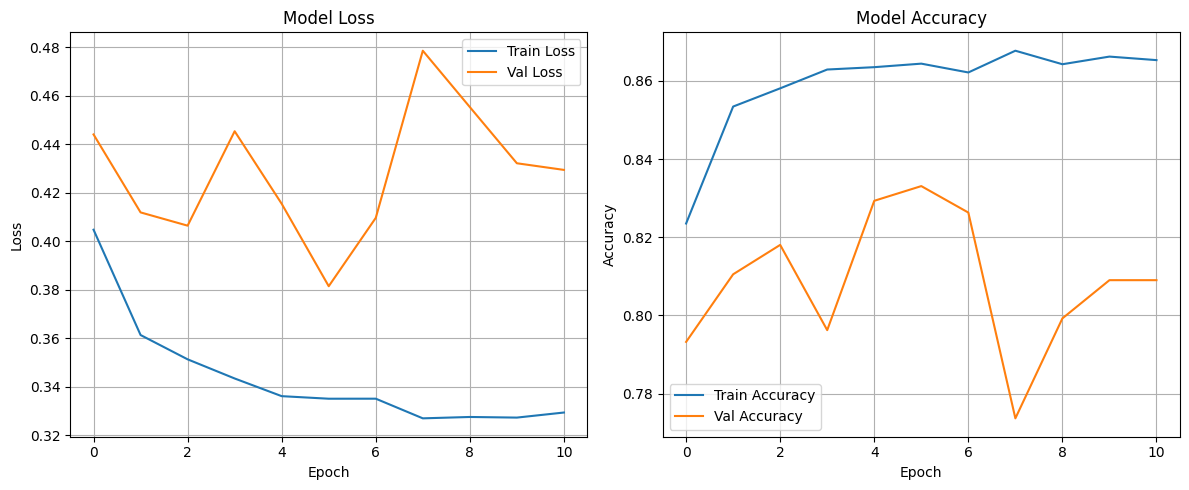

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# --- Loss ---
plt.subplot(1, 2, 1)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

# --- Accuracy ---
plt.subplot(1, 2, 2)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Val Accuracy")
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
